In [1]:
# 动量法。
def sgd_momentum(params, vs, lr, mom, batch_size):
    for param, v in zip(params, vs):
        v[:] = mom * v + lr * param.grad / batch_size
        param[:] -= v

In [2]:
import mxnet as mx
from mxnet import autograd
from mxnet import ndarray as nd
from mxnet import gluon
import random

mx.random.seed(1)
random.seed(1)

# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(scale=1, shape=y.shape)
dataset = gluon.data.ArrayDataset(X, y)

# 构造迭代器。
import random
def data_iter(batch_size):
    idx = list(range(num_examples))
    random.shuffle(idx)
    for batch_i, i in enumerate(range(0, num_examples, batch_size)):
        j = nd.array(idx[i: min(i + batch_size, num_examples)])
        yield batch_i, X.take(j), y.take(j)

# 初始化模型参数。
def init_params():
    w = nd.random_normal(scale=1, shape=(num_inputs, 1))
    b = nd.zeros(shape=(1,))
    params = [w, b]
    vs = []
    for param in params:
        param.attach_grad()
        # 把速度项初始化为和参数形状相同的零张量。
        vs.append(param.zeros_like())
    return params, vs

# 线性回归模型。
def net(X, w, b):
    return nd.dot(X, w) + b

# 损失函数。
def square_loss(yhat, y):
    return (yhat - y.reshape(yhat.shape)) ** 2 / 2

E:\software\anaconda\envs\gluon\lib\site-packages\urllib3\contrib\pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL


In [3]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt
import numpy as np

def train(batch_size, lr, mom, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    [w, b], vs = init_params()
    total_loss = [np.mean(square_loss(net(X, w, b), y).asnumpy())]

    # 注意epoch从1开始计数。
    for epoch in range(1, epochs + 1):
        # 重设学习率。
        if epoch > 2:
            lr *= 0.1
        for batch_i, data, label in data_iter(batch_size):
            with autograd.record():
                output = net(data, w, b)
                loss = square_loss(output, label)
            loss.backward()
            sgd_momentum([w, b], vs, lr, mom, batch_size)
            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X, w, b), y).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" %
              (batch_size, lr, epoch, total_loss[-1]))
    print('w:', np.reshape(w.asnumpy(), (1, -1)),
          'b:', b.asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

Batch size 10, Learning rate 0.200000, Epoch 1, loss 3.4819e-04
Batch size 10, Learning rate 0.200000, Epoch 2, loss 6.6013e-05
Batch size 10, Learning rate 0.020000, Epoch 3, loss 5.0524e-05
w: [[ 1.99991071 -3.39920688]] b: 4.19865 



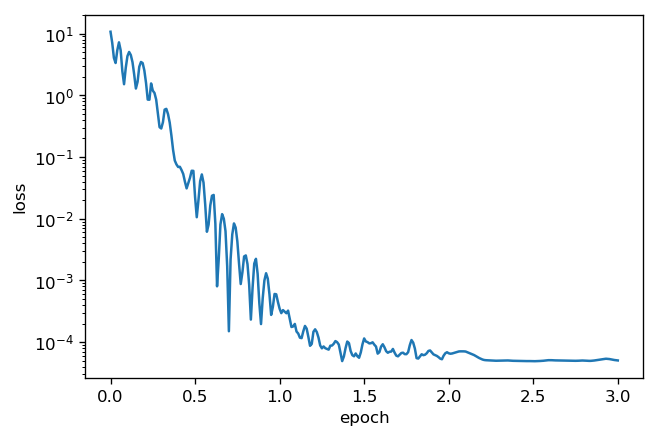

In [4]:
train(batch_size=10, lr=0.2, mom=0.9, epochs=3, period=10)

Batch size 10, Learning rate 0.200000, Epoch 1, loss 5.1080e-05
Batch size 10, Learning rate 0.200000, Epoch 2, loss 5.0408e-05
Batch size 10, Learning rate 0.020000, Epoch 3, loss 4.9034e-05
w: [[ 1.99989915 -3.40018344]] b: 4.20062 



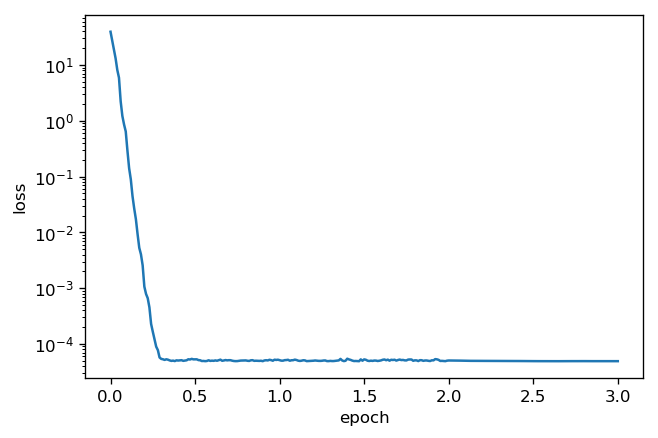

In [5]:
train(batch_size=10, lr=0.2, mom=0.1, epochs=3, period=10)

Batch size 10, Learning rate 0.200000, Epoch 1, loss 6.3278e+01
Batch size 10, Learning rate 0.200000, Epoch 2, loss 2.8932e+02
Batch size 10, Learning rate 0.020000, Epoch 3, loss 4.8415e+03
w: [[-79.78318787  34.10452652]] b: -31.9687 



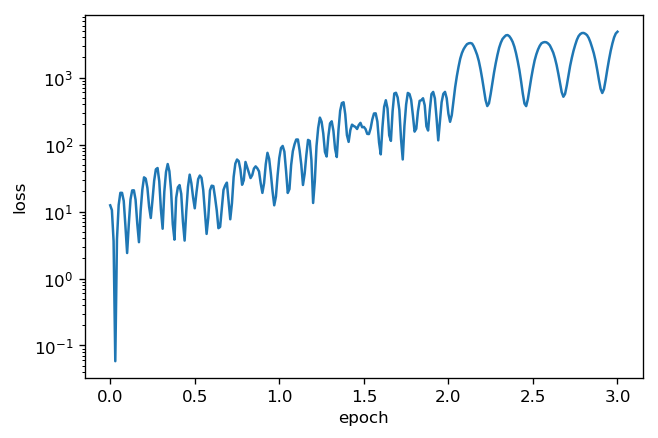

In [6]:
train(batch_size=10, lr=0.2, mom=0.999, epochs=3, period=10)

In [7]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def gluon_train(batch_size, lr, mom, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)
    # 动量法。
    trainer = gluon.Trainer(net.collect_params(), 'sgd',
                            {'learning_rate': lr, 'momentum': mom})
    data_iter = gluon.data.DataLoader(dataset, batch_size, shuffle=True)
    total_loss = [np.mean(square_loss(net(X), y).asnumpy())]

    for epoch in range(1, epochs + 1):
        # 重设学习率。
        if epoch > 2:
            trainer.set_learning_rate(trainer.learning_rate * 0.1)
        for batch_i, (data, label) in enumerate(data_iter):
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)

            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X), y).asnumpy()))
        print("Batch size %d, Learning rate %f, Epoch %d, loss %.4e" %
              (batch_size, trainer.learning_rate, epoch, total_loss[-1]))

    print('w:', np.reshape(net[0].weight.data().asnumpy(), (1, -1)),
          'b:', net[0].bias.data().asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

In [8]:
gluon_train(batch_size=10, lr=0.2, mom=0.9, epochs=3, period=10)

AttributeError: 'function' object has no attribute 'collect_params'